# Evolutionary Computing - N-Queens Problem

**Contents**: This notebook contains the updated n-queens problem, using the EC library (most notably the a004 part). The notebook is directly updated from assignment 1a to keep the same structure, and ease readibility of the grader. Cells not necessary for running the algorithm were deleted. The notebook contains an updated algorithm, which has been trimmed down in size compared to 1a due to the use of the library.

**Setup**

**Install Prerequisites**

In [1]:
# Run this cell to install the required libraries
%pip install numpy matplotlib scipy ariel

Note: you may need to restart the kernel to use updated packages.


**Imports**

In [ ]:
# Necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ranksums

# New necessary libraries for using ariel
from ariel.ec import a004
from functools import partial # For passing extra arguments to functions
import gc # For garbage collection (db file removal)
import os # For file operations (db file removal)

# Set seed
np.random.seed(42)

**Plotting**

In [3]:
# Enables inline matplotib graphs
# %matplotlib inline
%pip install PyQt5
# Comment the line above and uncomment the lines below to have interactive plots
# WARN: may cause dependency issues
#%matplotlib qt5
#%pip install PyQt5
#plt.ion()

Note: you may need to restart the kernel to use updated packages.


In [4]:
def generate_subplot_function(
    avgs_experiment_1,
    stds_experiment_1,
    labels,
    avgs_experiment_2,
    stds_experiment_2,
    n_columns,
    n_queens,
):
    """This helper function generates subplots for the experiments."""
    fig, axes = plt.subplots(nrows=1, ncols=n_columns, figsize=(18, 6))

    for i in range(len(avgs_experiment_1)):
        if avgs_experiment_2 is not None:
            # Plot data for subplot 1
            axes[i].plot(avgs_experiment_2[i], label="Experiment 2", color="green")
            axes[i].fill_between(
                np.arange(len(avgs_experiment_2[i])),
                avgs_experiment_2[i] - stds_experiment_2[i],
                avgs_experiment_2[i] + stds_experiment_2[i],
                alpha=0.2,
                color="green",
            )
            axes[i].set_ylim(bottom=0)

            if n_queens:
                axes[i].set_ylim(top=n_queens[i])

        axes[i].plot(avgs_experiment_1[i], label="Experiment 1", color="blue")
        axes[i].fill_between(
            np.arange(len(avgs_experiment_1[i])),
            avgs_experiment_1[i] - stds_experiment_1[i],
            avgs_experiment_1[i] + stds_experiment_1[i],
            alpha=0.2,
            color="blue",
        )
        axes[i].set_title(labels[i])
        axes[i].set_ylim(bottom=0)
        if n_queens:
            axes[i].set_ylim(top=n_queens[i])

    # Set common labels and title
    for ax in axes:
        ax.set_xlabel("Generations")
        ax.set_ylabel("Average Best Fitness")
        ax.legend()

    plt.tight_layout()

---

In [5]:
def visualize_solution(solution):
    """Visualize the placement of queens on the chessboard."""
    
    ################################################################
    
    #Get the number of rows and columns n and make a grid of dots
    n =len(solution)
    visual = np.full((n, n), ".", dtype=str)
    
    # For each row fill in a Q to show the column the queen is placed in
    for i,column in enumerate( solution):
        visual[i,column] = "Q"
    
    # For each row in the array, print the row connected by spaces in between (print automatically handles newline)
    for row in visual:
        print(" ".join(row))

    ################################################################

Write the evaluation function to assess how good your solution is.

In [6]:
def evaluate_solution_n_queens(solution):
    """Calculate the fitness of an solution."""
    ################################################################
    #Set initial fitness to the maximum number of queens, if no conflicts arise, this is the fitness.
    fitness = len(solution)
    
    # For each row (and queen) check if there exists a conflict with another queen that has not been checked yet, 
    # if so, reduce the fitness by one. 
    # The fitness thus becomes the amount of queens that need to be removed for a non-conflict solution
    
    for i in range(len(solution)):
        conflict = False
        for j in range(i+1, len(solution)):
            # If the difference between the column index of 2 queens is the same as the difference in row index, 
            # then the slope is 1 (or -1 thus the absolute value), such that they must lie on the same diagonal 
            #which by definition has slope 1
            if abs(solution[i]- solution[j]) == abs(i-j):
                conflict =True
        if conflict:        
            fitness -=1

    ################################################################

    return fitness

In [7]:
evaluate_solution_n_queens([2,0,3,1])

4

Try your implementations to see if your solution encoding matches to visualization and whether the fitness is computed correctly.

---



### **Task 2 (0-0.4-0.8-1.2-1.6 pt):** 
Write an evolutionary algorithm that can initialize a population of solutions and finds N queen placement to NxN board optimizing the number of attacks (could be minimization or maximization based on your evaluation function of the solutions).

In [ ]:


def initialization_n_queens(population_size, num_of_dims):
    """Generate a population of solutions using a004.Individual."""
    # Use a004.Individual to create individuals, with genotype of the permutation of numbers from 0 to num_of_dims-1
    population = []
    for _ in range(population_size):
        ind = a004.Individual()  # create an Individual
        ind.genotype = [int(i) for i in np.random.permutation(num_of_dims)]  # set the genotype
        population.append(ind)
    return population


def evaluation_n_queens(x):
    """Evaluate the fitness of required individuals using evaluate_solution_n_queens (custom function)."""
    for ind in x:
        if ind.requires_eval:
            ind.fitness = evaluate_solution_n_queens(ind.genotype)
    return x


def crossover_n_queens(x, p_crossover):
    """Perform crossover to create offsprings using a005.crossover."""
    parents = [ind for ind in x if ind.tags.get("ps", False)]
    for i in range(0, len(parents), 2):
        parent_a = parents[i]
        parent_b = parents[(i+1)%len(parents)]

        # Only apply crossover when the random number is less than p_crossover, else append parents
        if np.random.rand() < p_crossover:
            # Perform one-point crossover, which is similar to a004 crossover but adapted for permutations
            genei, genei = a004.Crossover.one_point(parent_a.genotype, parent_b.genotype)

            # First child
            child_i = a004.Individual()
            child_i.genotype = genei
            child_i.tags = {"mut": True}

            # Second child
            child_j = a004.Individual()
            child_j.genotype = genei
            child_j.tags = {"mut": True}

            x.append(child_i)
            x.append(child_j)
        else:
            x.append(parent_a)
            x.append(parent_b)
    return x


def mutation_n_queens(x, mutation_rate):
    """Apply mutation to an individual using a005.mutate."""
    for ind in x:
        # Mutate with a probability of mutation_rate
        # It was chosen that both crossover and mutation should be possible in the same generation, increasing diversity    
        if np.random.rand() < mutation_rate:
            mutate_solution = ind.genotype.copy()
            index_1, index_2 = np.random.choice(len(mutate_solution), size=2, replace=False)
            # Swap indices
            mutate_solution[index_1], mutate_solution[index_2] = mutate_solution[index_2], mutate_solution[index_1]
            ind.genotype = mutate_solution
            ind.requires_eval = True
    return x


def parent_selection_n_queens(x):
    # Use the parent_selection function from a004, whch uses tournament selection (k=2) by default
    selected_population = a004.parent_selection(x)
    return selected_population


def survivor_selection_n_queens(x):
    # Use the parent_selection function from a004, whch uses tournament selection (k=2) by default
    x_survivors = a004.survivor_selection(x)
    return x_survivors

def ea_n_queens(population_size, max_fit_evals, p_crossover, m_rate, num_of_dims):
    
    number_of_generations = max_fit_evals // population_size
    population_list = initialization_n_queens(population_size, num_of_dims)
    # Create EA steps
    ops = [
        a004.EAStep("evaluation", evaluation_n_queens), # Start with evaluation to avoid unevaluated individuals
        a004.EAStep("survivor_selection", survivor_selection_n_queens), # Manage population (does nothing first generation)
        a004.EAStep("parent_selection", parent_selection_n_queens), # Select parents for crossover
        a004.EAStep("crossover", partial(crossover_n_queens, p_crossover=p_crossover)), # Crossover, use patial for passing extra arguments
        a004.EAStep("mutation", partial(mutation_n_queens, mutation_rate=m_rate)), # Mutate (might end up with larger last generation, but best solution will always be kept, so the final solution is equivalent)

    ]
    
    # Initialize the EA, using a004, which makes the process shorter
    ea = a004.BasicEA(population = population_list,
                        operations=ops,
                        num_of_generations=number_of_generations)

    # Run the EA manually to be able to store best solutions at each generation
    best_x= []
    best_f =[]
    for _ in range(ea.num_of_generations):
        ea.step()
        best = ea.get_solution(only_alive=False)
        best_x.append(best.genotype)
        best_f.append(best.fitness)

    # Delete the reference to the EA to allow for deleting the database file
    del ea  # remove the reference
    gc.collect()  # force garbage collection

    # Remove the database file created by a004 to avoid delete warnings in future runs
    db_path = "__data__/database.db"
    if os.path.exists(db_path):
        os.remove(db_path)

    return best_x, best_f


---
**Results:**

Run the code below to run an EA for N=8, 16 and 32, and visualize the best solutions found.
Note, it is not allowed to change the hyper parameters


In [9]:
print("Case when N=8:")
x_best, f_best = ea_n_queens(10, 1000, 0.5, 0.1, 8)


print("Best fitness:", f_best[-1])
print("Best solution found:")
visualize_solution(x_best[-1])


Case when N=8:


───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Best fitness: 8.0
Best solution found:
. . . Q . . . .
. . . . . . Q .
. . . Q . . . .
. . . . . Q . .
. . Q . . . . .
. . . . . Q . .
. . . Q . . . .
. . . . . . Q .


In [10]:
print("Case when N=16:")
x_best, f_best = ea_n_queens(100, 10000, 0.5, 0.1, 16)


print("Best fitness:", f_best[-1])
print("Best solution found:")
visualize_solution(x_best[-1])

Case when N=16:


───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Best fitness: 16.0
Best solution found:
Q . . . . . . . . . . . . . . .
. . . Q . . . . . . . . . . . .
. . . . . . . . . . . . . Q . .
. . . . . . . Q . . . . . . . .
. . . . . Q . . . . . . . . . .
. . . . . . . . . . . . . . Q .
. Q . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . Q
. . . . . . Q . . . . . . . . .
. . . Q . . . . . . . . . . . .
. . . . . . . . . . . . . Q . .
. . Q . . . . . . . . . . . . .
. . . . . Q . . . . . . . . . .
. . . . . . . . . . . . Q . . .
. . . . . . Q . . . . . . . . .
. . . . . . . . . . . . Q . . .


In [11]:
print("Case when N=32:")
x_best, f_best = ea_n_queens(100, 10000, 0.5, 0.1, 32)

print("Best fitness:", f_best[-1])
print("Best solution found:")
visualize_solution(x_best[-1])

Case when N=32:


───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Best fitness: 31.0
Best solution found:
. . . . . . . . . Q . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . Q . . . . . . . . . . . . .
. . Q . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . Q . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . Q . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Q .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . Q . . .
. . . . . . . . . . . . . . . . . . . . Q . . . . . . . . . . .
Q . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . Q . . . . . . . . . . . . . . . . . . . .
Q . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Q
. . . . . . . . . . . . . . . . . . . . . . . . . . Q . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . Q . . . . . . .
. . . . . . . . . . . . . . . . . . . Q . . . . . . . . . . . .


---

### Plotting the average performance of the algorithm
Use the cells below to plot the results of your algorithm. The plots should show average and std of 10 runs of EA for n-queens problem for N=8, 16, 32.

In [12]:
def calculate_mean_std(f_best):
    """This is a helper function to calculate the mean and standard deviation of the best fitness values."""
    f_best = np.array(f_best)
    avg = np.mean(f_best, axis=0)
    std = np.std(f_best, axis=0)
    return avg, std

In [13]:
def run_experiment_n_queens(population_size, p_crossover, m_rate):

    # These are the hyperparameters of your evolutionary algorithm. You are not allowed to change them.
    runs = 10
    max_fit_evals = 10000


    fitness_8 = []
    fitness_16 = []
    fitness_32 = []



    for run in range(runs):
        print("Run: ", run)

        _, f_best_8 = ea_n_queens(
            population_size[0], max_fit_evals, p_crossover[0], m_rate[0], num_of_dims=8
        )
        _, f_best_16 = ea_n_queens(
            population_size[1], max_fit_evals, p_crossover[1], m_rate[1], num_of_dims=16
        )
        _, f_best_32 = ea_n_queens(
            population_size[2], max_fit_evals, p_crossover[2], m_rate[2], num_of_dims=32
        )
        fitness_8.append(f_best_8)
        fitness_16.append(f_best_16)
        fitness_32.append(f_best_32)

    avg_8, std_8 = calculate_mean_std(fitness_8)
    avg_16, std_16 = calculate_mean_std(fitness_16)
    avg_32, std_32 = calculate_mean_std(fitness_32)

    avgs = [avg_8, avg_16, avg_32]
    stds = [std_8, std_16, std_32]
    all_runs = [fitness_8, fitness_16, fitness_32]

    return avgs, stds, all_runs

In [14]:
population_size = [100, 100, 100]  # not allowed to change
p_crossover = [0.8, 0.8, 0.8]  # not allowed to change
m_rate = [0.1, 0.1, 0.1]  # not allowed to change

avgs_experiment_1, stds_experiment_1, all_runs_experiment_1 = run_experiment_n_queens(
    population_size, p_crossover, m_rate
)

Run:  0


───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Run:  1


───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Run:  2


───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Run:  3


───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Run:  4


───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Run:  5


───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Run:  6


───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Run:  7


───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Run:  8


───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Run:  9


───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

In [15]:
#check for the best fitness found for each problem

f_8, f_16, f_32 = all_runs_experiment_1

print("Best fitness found for N = 8: ", max(max(f_8)))
print("Best fitness found for N = 16: ", max(max(f_16)))
print("Best fitness found for N = 32: ", max(max(f_32)))

Best fitness found for N = 8:  8.0
Best fitness found for N = 16:  16.0
Best fitness found for N = 32:  32.0


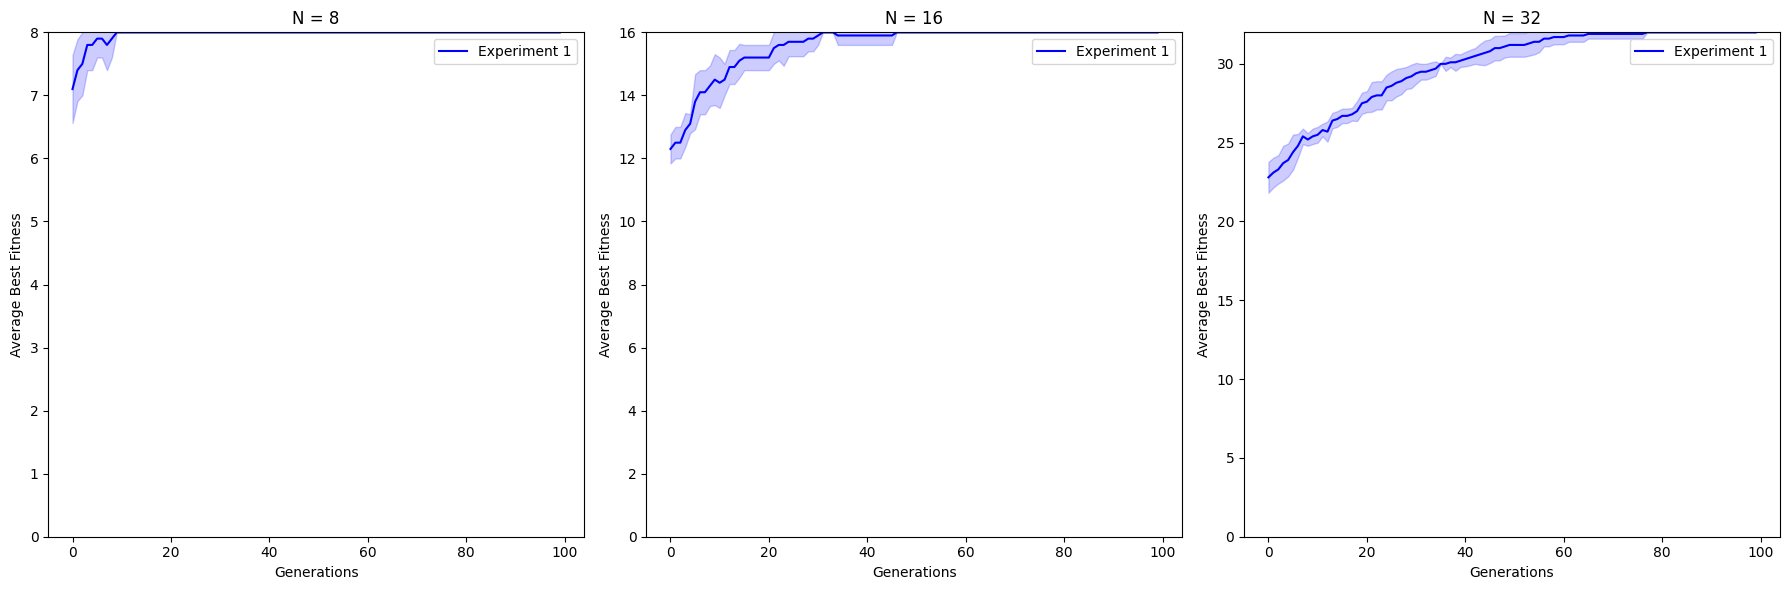

In [16]:
labels = ["N = 8", "N = 16", "N = 32"]

generate_subplot_function(
    avgs_experiment_1,
    stds_experiment_1,
    labels,
    avgs_experiment_2=None,
    stds_experiment_2=None,
    n_columns=3,
    n_queens=[8, 16, 32],
)

### **Question 4 (0-0.4 pt):** 
* Results
The algorithm performs noticably better than the one I created myself, reaching the highest possible number of queens even on the n=32 case on average. Furthermore, the case for n=16 converges faster
